# MaskRCNN Training | HuBMAP - Hacking the Human Vasculature Competition

[EDA](https://www.kaggle.com/code/khalilrejiba/hubmap-vasculature-eda-interactive)

## Utility Scripts

In [1]:
!pip -q install cython
!pip install -qU pycocotools 

In [2]:
!git clone https://github.com/pytorch/vision.git
%cd /kaggle/working/vision
!git checkout 59ec1df
%cd /kaggle/working

Cloning into 'vision'...
remote: Enumerating objects: 382288, done.
remote: Counting objects: 100% (32528/32528), done.
remote: Compressing objects: 100% (1962/1962), done.
remote: Total 382288 (delta 30670), reused 32228 (delta 30456), pack-reused 349760
Receiving objects: 100% (382288/382288), 759.45 MiB | 33.17 MiB/s, done.
Resolving deltas: 100% (353196/353196), done.
/kaggle/working/vision
Note: switching to '59ec1df'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 59ec1dfd55 support amp training for dete

In [3]:
%%bash
cp vision/references/detection/utils.py /kaggle/working
cp vision/references/detection/engine.py /kaggle/working
cp vision/references/detection/coco_eval.py /kaggle/working
cp vision/references/detection/coco_utils.py /kaggle/working
cp vision/references/detection/transforms.py /kaggle/working

## Import Statements

In [4]:
import numpy as np
import pandas as pd
import json
from pathlib import Path
import gc
import matplotlib.pyplot as plt
import PIL
import skimage
from shapely.geometry import LinearRing as ShapelyContour
from shapely.geometry import Polygon as ShapelyPolygon
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2

from pycocotools import _mask as coco_mask
import base64
import zlib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Setting Global Variables

In [5]:
# For reproducibility
seed = 123
random.seed(seed) # Used in Albumentations
np.random.seed(seed)
torch.manual_seed(seed);

In [6]:
TRAIN_DIR = "/kaggle/input/hubmap-hacking-the-human-vasculature/train"
TEST_DIR = "/kaggle/input/hubmap-hacking-the-human-vasculature/test"
ANNOT_PATH = "/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl"
WSI_TILE_CSV = "/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv"
IMG_SIZE = 512

In [7]:
hidden_test_ids = [path.stem for path in Path(TEST_DIR).glob("*.tif")]

In [8]:
class_names = ["background", "blood_vessel", "glomerulus", "unsure"]

wsi_df = pd.read_csv(WSI_TILE_CSV)
# Tiles with Annotations
dataset12_ids = wsi_df[wsi_df["dataset"] != 3].id.values.tolist() 
# Tiles with Expert Reviewed Annotations
dataset1_ids = wsi_df[wsi_df["dataset"] == 1].id.values.tolist()
# Tiles with Sparse Annotations
dataset2_ids = wsi_df[wsi_df["dataset"] == 2].id.values.tolist()
# Tiles without Annotations
dataset3_ids = wsi_df[wsi_df["dataset"] == 3].id.values.tolist() 

# Preprocessing

In [9]:
def load_annotations(annotations_path=ANNOT_PATH):
    
    annotations = {}
    duplicates_ids = []

    with open(annotations_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            identifier = entry["id"]
            annotations_list = entry["annotations"]

            revised_annotations = [] # [[label_str, polygon_list], ...]

            for annotation in annotations_list:
                label = annotation["type"]
                polygon = annotation["coordinates"][0]

                # Remove Duplicates
                if not any(ShapelyContour(p).equals(ShapelyContour(polygon)) and l==label for l, p in revised_annotations):
                    revised_annotations.append([label, polygon])

            if len(annotations_list) != len(revised_annotations):
                duplicates_ids.append(identifier)

            annotations[identifier] = revised_annotations
    return annotations, duplicates_ids

def clean_annotations(annotations):
    
    new_annotations = {}
    anomalies_ids = []

    for identifier in annotations.keys():

        annotations_list = annotations[identifier]
        revised_annotations = []
        skip = False

        for (label, polygon) in annotations_list:

            for i, (l, p) in enumerate(revised_annotations):
                # New Polygon Inside Old Polygon -> Skip New
                if ShapelyPolygon(p).buffer(0).contains(ShapelyPolygon(polygon).buffer(0)):
                    skip = True
                    break
                # Old Polygon Inside New Polygon -> Delete Old
                if ShapelyPolygon(p).buffer(0).within(ShapelyPolygon(polygon).buffer(0)):
                    revised_annotations.pop(i)
            if skip:
                continue
            revised_annotations.append([label, polygon])

        if len(annotations_list) != len(revised_annotations):
            anomalies_ids.append(identifier)

        new_annotations[identifier] = revised_annotations

    return new_annotations, anomalies_ids 

In [10]:
annotations, _ = load_annotations()
annotations, _ = clean_annotations(annotations)
assert len(annotations) == len(dataset12_ids)

In [11]:
def prepare_gt_instance_seg(identifiers, annotations, class_names, keep_only=None, erode=0):
    """
    Transform polygon annotations into instance masks
    """   
    num_classes = len(class_names) - 1
    if keep_only is None: 
        mask_shape = (IMG_SIZE, IMG_SIZE, num_classes)
    else:
        mask_shape = (IMG_SIZE, IMG_SIZE)
    new_ids, masks, polygons = [], [], []
        
    for identifier in identifiers:
        
        labeled_mask = np.zeros(mask_shape, dtype="uint8")
        overlap = np.zeros(mask_shape, dtype="uint8")
        polygons_list = [] # [[label_int, polygon_list], ...]
        
        num_objects = 0
        
        for (label, polygon) in annotations[identifier]:
            if label == keep_only or keep_only is None:
                num_objects += 1
                label_int = class_names.index(label)
                polygons_list.append([label_int, polygon])
                mask = skimage.draw.polygon2mask(mask_shape[:2], polygon).T
                if erode:
                    mask = skimage.morphology.erosion(mask, skimage.morphology.square(7))
                    
                if keep_only is None: 
                    intersection = (labeled_mask * np.stack([mask]*num_classes, axis=-1)) > 0
                else:
                    intersection = (labeled_mask * mask) > 0
                    
                if intersection.sum():
                    overlap += intersection
                    
                if keep_only is None: 
                    labeled_mask[:,:,label_int-1] += (num_objects * mask).astype("uint8")
                else:
                    labeled_mask += (num_objects * mask).astype("uint8")
        
        # Overlap is treated as background
        labeled_mask[overlap > 0] = 0
        
        if labeled_mask.sum() == 0:
            continue
            
        new_ids.append(identifier)
        masks.append(labeled_mask)
        polygons.append(polygons_list)
    
    masks = np.array(masks) # (N, H, W) or (N, H, W, C)
    
    return new_ids, masks, polygons

In [12]:
def shuffle_sequence(seq):
    array = np.array(seq)
    np.random.shuffle(array)
    return array.tolist()

def retrieve_identifiers(wsi_df, source, shuffle=True):
    array = wsi_df[wsi_df["source"]==source].id.values.tolist()
    if shuffle:    
        return shuffle_sequence(array)
    return array

wsi_df = pd.read_csv(WSI_TILE_CSV)
wsi_df["source"] = wsi_df[["dataset", "source_wsi"]].apply(tuple, axis=1)

source11 = retrieve_identifiers(wsi_df, (1, 1))
source12 = retrieve_identifiers(wsi_df, (1, 2))
source21 = retrieve_identifiers(wsi_df, (2, 1))
source22 = retrieve_identifiers(wsi_df, (2, 2))
source23 = retrieve_identifiers(wsi_df, (2, 3))
source24 = retrieve_identifiers(wsi_df, (2, 4))

valid_ids = source11[:50] + source12[:50]
train_ids = source11[50:] + source12[50:] + source21 + source22 + source23 + source24

In [13]:
class HuBMAPVasculatureDataset(Dataset):
    
    def __init__(self, ids, masks=None, root=TRAIN_DIR, transforms=None):
        self.root = root
        self.ext = "tif"
        self.transforms = transforms
        self.ids = ids
        self.masks = masks
        self.multiclass = masks.ndim == 4

    def __getitem__(self, idx):
        img_path = Path(self.root) / f"{self.ids[idx]}.{self.ext}"
        img = PIL.Image.open(img_path).convert("RGB")
        img = np.array(img)
        mask = self.masks[idx]
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        
        if self.multiclass:
            masks = (mask == obj_ids[:, None, None, None])
            labels = (np.argmax(np.any(masks, axis=(1, 2)), axis=-1) + 1).astype(np.int64)
            masks = np.any(masks, axis=-1).astype("uint8")
        else:
            masks = (mask == obj_ids[:, None, None]).astype("uint8")
            labels = np.ones((num_objs,), dtype=np.int64)

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = np.array(boxes, dtype=np.float32)
        
        image_id = torch.tensor(idx)
        area = torch.as_tensor((boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]))
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area # Can't rely on area after augmentation
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            target["masks"] = np.transpose(target["masks"], (1, 2, 0))
            
            data = self.transforms(image=img, bboxes=target["boxes"], mask=target["masks"], class_labels=target["labels"])

            img = data["image"] / 255.
            target["masks"] = data["mask"]
            target["boxes"] = torch.as_tensor(data["bboxes"], dtype=torch.float32)
            target["labels"] = torch.as_tensor(data["class_labels"], dtype=torch.int64)

        return img, target

    def __len__(self):
        return len(self.ids)

In [14]:
class HuBMAPVasculatureTestset(Dataset):
    
    def __init__(self, ids, root=TEST_DIR, transforms=None):
        self.root = root
        self.ext = "tif"
        self.ids = ids
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path = Path(self.root) / f"{self.ids[idx]}.{self.ext}"
        img = PIL.Image.open(img_path).convert("RGB")
        img = np.array(img)
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        return img / 255

    def __len__(self):
        return len(self.ids)

In [15]:
def get_instance_segmentation_model(num_classes=2, hidden_layer=256):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [16]:
def get_transforms(train=False, s=IMG_SIZE):
    transforms = [
        A.Resize(height=s, width=s),
    ]
    if train:
        transforms.extend([
#             A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=(-0.01, 0.1), rotate_limit=5, border_mode=4),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ColorJitter (p=0.5, brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
        ])  
    transforms.append(ToTensorV2(transpose_mask=True)) 
    
    transforms = A.Compose(
        transforms,
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], 
                                 min_area=0, min_visibility=0)
    )
    
    return transforms

# With ShiftScaleRotate, you risk having images with no objects

In [17]:
def get_transforms_pred(s=IMG_SIZE):
    transforms = [
        A.Resize(height=s, width=s),
        ToTensorV2()
    ]    
    transforms = A.Compose(transforms)
    return transforms

 Under the hood, the MaskRCNN model uses the following preprocessing steps:   
  (transform): GeneralizedRCNNTransform(  
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
      Resize(min_size=(800,), max_size=1333, mode='bilinear')  
  )

In [18]:
ids, masks_gt, polygons_gt = prepare_gt_instance_seg(dataset12_ids,
                                                     annotations,
                                                     class_names)

In [19]:
gc.collect()

0

In [20]:
MASK_DIR = Path("/kaggle/working") / "masks"
MASK_DIR.mkdir(parents=True, exist_ok=True)
for identifier, mask in zip(ids, masks_gt):
    path = MASK_DIR / f"{identifier}.npy"
    np.save(path, mask)

In [21]:
train_indices = [ids.index(i) for i in train_ids if i in ids]
valid_indices = [ids.index(i) for i in valid_ids if i in ids]

train_dataset = HuBMAPVasculatureDataset(ids, masks_gt, transforms=get_transforms(train=True))
valid_dataset = HuBMAPVasculatureDataset(ids, masks_gt, transforms=get_transforms(train=False))
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(valid_dataset, valid_indices)

# Training

In [22]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=16, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn
)

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs = 10
SAVE_PATH = f"maskrcnn_resnet50_fpn_finetune_{num_epochs}epochs.pth"

train_success = False
num_try = 0
while not train_success and num_try < 10:
    try:
        model = get_instance_segmentation_model(num_classes=len(class_names))
        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params,
                                    lr=0.005,
                                    momentum=0.9,
                                    weight_decay=0.0005)

        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                       step_size=3,
                                                       gamma=0.1)
    
        mean_ap_best = 0

        for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=500)
            if epoch >= (num_epochs//2):
                lr_scheduler.step()
            torch.cuda.empty_cache()
            coco_evaluator = evaluate(model, valid_loader, device=device)
            mean_ap = coco_evaluator.coco_eval["segm"].stats[0]
            if mean_ap > mean_ap_best:
                mean_ap_best = mean_ap
                print("Saving checkpoint: mAP = ", mean_ap_best)
                torch.save(model.state_dict(), SAVE_PATH)
        train_success = True
        
    except (RuntimeError, ConnectionRefusedError, EOFError) as e:
        print(e)
        num_try += 1
        torch.cuda.empty_cache()
        gc.collect()
        pass
    
if train_success:
    print("Finished training succesfully!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 209MB/s]


Epoch: [0]  [  0/192]  eta: 0:27:21  lr: 0.000031  loss: 5.0541 (5.0541)  loss_classifier: 1.3771 (1.3771)  loss_box_reg: 0.1258 (0.1258)  loss_mask: 1.5007 (1.5007)  loss_objectness: 1.9828 (1.9828)  loss_rpn_box_reg: 0.0676 (0.0676)  time: 8.5514  data: 1.2342  max mem: 5828
Epoch: [0]  [191/192]  eta: 0:00:02  lr: 0.005000  loss: 1.1450 (1.4858)  loss_classifier: 0.2807 (0.3724)  loss_box_reg: 0.3882 (0.3892)  loss_mask: 0.3036 (0.4248)  loss_objectness: 0.0886 (0.2300)  loss_rpn_box_reg: 0.0524 (0.0694)  time: 2.1276  data: 1.1536  max mem: 7201
Epoch: [0] Total time: 0:07:08 (2.2337 s / it)
creating index...
index created!
Test:  [0/7]  eta: 0:00:29  model_time: 2.1073 (2.1073)  evaluator_time: 0.9187 (0.9187)  time: 4.2007  data: 1.1619  max mem: 7397
Test:  [6/7]  eta: 0:00:05  model_time: 2.1073 (1.9328)  evaluator_time: 0.9187 (1.3464)  time: 5.1610  data: 1.8163  max mem: 7397
Test: Total time: 0:00:36 (5.1612 s / it)
Averaged stats: model_time: 2.1073 (1.9328)  evaluator_tim

# Post-processing

In [24]:
model.load_state_dict(torch.load(SAVE_PATH))

<All keys matched successfully>

In [25]:
def apply_nms_box(boxes, scores, iou_thres=0.5):
    """
    Non Maximum Suppression using bounding boxes
    """
    x0 = boxes[:, 0]
    y0 = boxes[:, 1]
    x1 = boxes[:, 2]
    y1 = boxes[:, 3]

    areas = (x1 - x0) * (y1 - y0)

    indices = scores.argsort(descending=True)
 
    revised_indices = []
    
    while len(indices) > 0:
        
        idx = indices[0]
        indices = indices[1:]
        revised_indices.append(idx.item())
        
        xx0 = torch.max(x0[indices], x0[idx])
        yy0 = torch.max(y0[indices], y0[idx])
        xx1 = torch.min(x1[indices], x1[idx])
        yy1 = torch.min(y1[indices], y1[idx])
         
        w = torch.clamp(xx1 - xx0, min=0)
        h = torch.clamp(yy1 - yy0, min=0)
        intersection = w * h
        union = areas[indices] - intersection
        IoU = intersection / union

        indices = indices[IoU < iou_thres]

    return revised_indices

In [26]:
def apply_nms_mask(masks, scores, iou_thres=0.5):
    """
    Non Maximum Suppression using masks
    """
    indices = scores.argsort(descending=True)
 
    revised_indices = []
    
    while len(indices) > 0:
        
        idx = indices[0]
        indices = indices[1:]
        revised_indices.append(idx.item())
         
        intersection = masks[indices] * masks[idx]
        union = masks[indices] + masks[idx]
        union = union.clip(0, 1)

        IoU = intersection.sum(dim=(1, 2, 3)) / union.sum(dim=(1, 2, 3))

        indices = indices[IoU < iou_thres]

    return revised_indices

In [27]:
def get_predictions(model, img, label=1, conf_thres=0.5, iou_thres=0.6, nms_mask=True):
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    prediction = prediction[0]
    
    conf_filter = prediction['scores'] > conf_thres
    label_filter = prediction['labels'] == label
    for k, v in prediction.items():    
        prediction[k] = v[conf_filter * label_filter]
    
    masks = prediction['masks']
    boxes = prediction['boxes']
    scores = prediction['scores']
    
    # Soft Masks to Binary Masks
    masks = (masks >  0.5).byte()
    
    # Non Maximum Suppression
    if nms_mask:
        indices = apply_nms_mask(masks, scores, iou_thres)
    else:
        indices = apply_nms_box(boxes, scores, iou_thres)

    return masks[indices].cpu().numpy(), boxes[indices].cpu().numpy(), scores[indices].cpu().numpy()

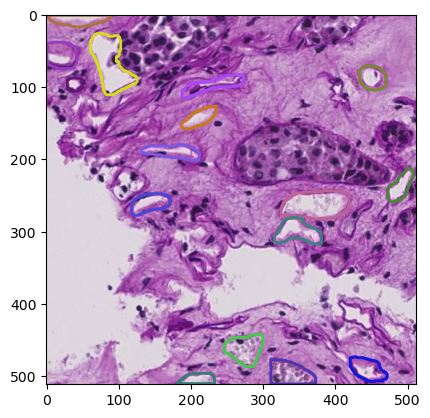

In [28]:
test_dataset = HuBMAPVasculatureTestset(hidden_test_ids, transforms=get_transforms_pred())

img = test_dataset[np.random.randint(len(test_dataset))]

plt.imshow(img.permute(1, 2, 0))

masks, _, _ = get_predictions(model, img)

for mask in masks:
    mask = mask.squeeze()
    polygon = skimage.measure.find_contours(mask)[0]
    yy, xx = zip(*polygon)
    plt.fill(xx, yy, facecolor='none', edgecolor=np.random.random(size=3), linewidth=2)

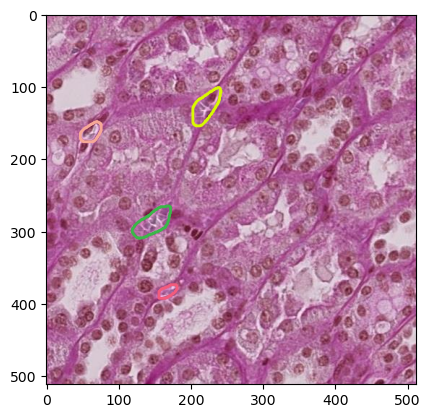

In [29]:
test_dataset = HuBMAPVasculatureTestset(dataset3_ids, root=TRAIN_DIR, transforms=get_transforms_pred())

img = test_dataset[np.random.randint(len(test_dataset))]

plt.imshow(img.permute(1, 2, 0))

masks, _, _ = get_predictions(model, img)

for mask in masks:
    mask = mask.squeeze()
    polygon = skimage.measure.find_contours(mask)[0]
    yy, xx = zip(*polygon)
    plt.fill(xx, yy, facecolor='none', edgecolor=np.random.random(size=3), linewidth=2)

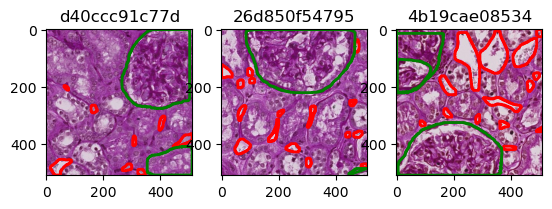

In [30]:
glomerus_ids = ["d40ccc91c77d", "26d850f54795", "4b19cae08534"] # Dataset 3 (unseen)
test_dataset = HuBMAPVasculatureTestset(glomerus_ids, root=TRAIN_DIR, transforms=get_transforms_pred())

colors = ["red", "green", "blue"]

fig, axs = plt.subplots(1, 3)

for idx, image_id in enumerate(glomerus_ids):
    ax = axs[idx]
    ax.set_title(image_id)
    
    img = test_dataset[idx]
    ax.imshow(img.permute(1, 2, 0))
    
    for label_id in range(1, 4):
        masks, _, _ = get_predictions(model, img, label=label_id)
        for mask in masks:
            mask = mask.squeeze()
            polygon = skimage.measure.find_contours(mask)[0]
            yy, xx = zip(*polygon)
            ax.fill(xx, yy, facecolor='none', edgecolor=colors[label_id-1], linewidth=2)

In [31]:
def show_grid(dataset, tile_ids, masks, polygons, class_names, model=None, nrows=2, ncols=2, divide_by=2, dpi=100):
    figsize = (((IMG_SIZE/divide_by)*ncols)/dpi, ((IMG_SIZE/divide_by)*nrows)/dpi)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        identifier = tile_ids[i]
        img = dataset[i]
        mask = masks[i]
        polygons_list = polygons[i]
        ax.imshow(img.cpu().permute(1, 2, 0))
        ax.imshow(mask, alpha=0.25, cmap="turbo", interpolation="nearest")
        if model is not None:
            for mask in get_predictions(model, img)[0]:
                mask = mask.squeeze()
                polygon = skimage.measure.find_contours(mask)[0]
                yy, xx = zip(*polygon)
                ax.fill(xx, yy, facecolor='none', edgecolor="blue", linewidth=1)
        for label, polygon in polygons_list:
            xx, yy = zip(*polygon)
            if label == 1:
                ax.fill(xx, yy, facecolor='none', edgecolor="lightgreen", linewidth=1)
            elif label == 2:
                ax.fill(xx, yy, facecolor='none', edgecolor="red", linewidth=1)
            else:
                ax.fill(xx, yy, facecolor='none', edgecolor="lightgreen", linestyle="--", linewidth=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
    fig.show()

In [32]:
dataset = HuBMAPVasculatureTestset(ids, transforms=get_transforms_pred(), root=TRAIN_DIR)

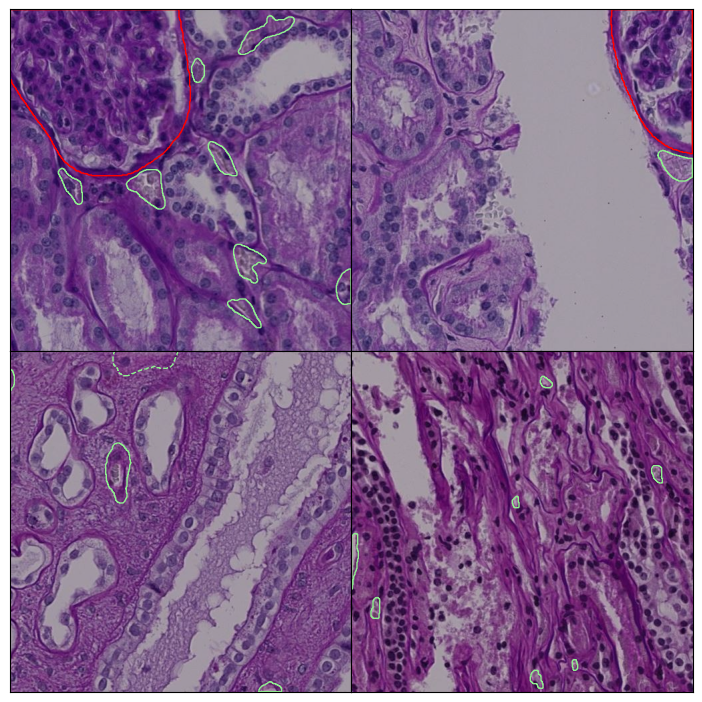

In [33]:
# Display Ground Truth
show_grid(dataset, ids, masks_gt, polygons_gt, class_names, divide_by=1.5)

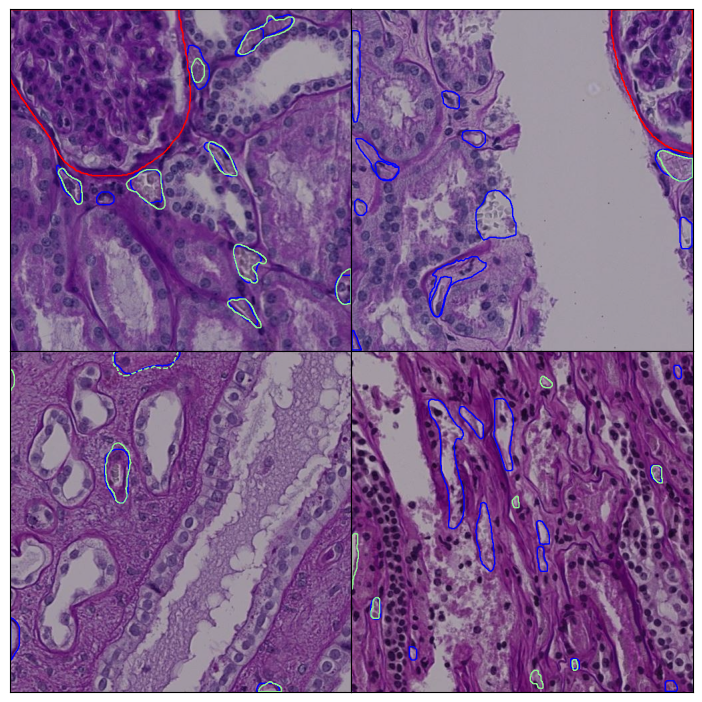

In [34]:
# Display Ground Truth and Model Predictions
show_grid(dataset, ids, masks_gt, polygons_gt, class_names, model, divide_by=1.5)

#  Submission

In [35]:
def encode_mask(mask):
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

In [36]:
submission_list = []
for i, test_id in enumerate(hidden_test_ids):
    prediction_string = ""
    
    img = test_dataset[i]
    _, h, w = img.shape
    masks, _, scores = get_predictions(model, img)
    masks_glomerulus, _, _ = get_predictions(model, img, label=2)
    for mask, score in zip(masks, scores):
        for glm_msk in masks_glomerulus:
            # Test if vessel is mainly outside glomerulus
            intersection = mask * glm_msk
            if intersection.sum() < 0.5 * mask.sum():
                mask = mask.squeeze()
                mask_str = encode_mask(mask).decode('UTF-8')
                prediction_string += f"0 {score} {mask_str} "
                entry = {
                    "id": test_id,
                    "height": h,
                    "width": w,
                    "prediction_string": prediction_string,
                }
                submission_list.append(entry)

In [37]:
submission_df = pd.DataFrame(submission_list)
submission_df = submission_df.set_index('id')
submission_df.to_csv("submission.csv")

In [38]:
submission_df.head()

,height,width,prediction_string
id,,,
72e40acccadf,512,512,0 0.9881613254547119 eNpVjb0KgEAMg18p7cG5iOLi1...
72e40acccadf,512,512,0 0.9881613254547119 eNpVjb0KgEAMg18p7cG5iOLi1...
72e40acccadf,512,512,0 0.9881613254547119 eNpVjb0KgEAMg18p7cG5iOLi1...
72e40acccadf,512,512,0 0.9881613254547119 eNpVjb0KgEAMg18p7cG5iOLi1...
72e40acccadf,512,512,0 0.9881613254547119 eNpVjb0KgEAMg18p7cG5iOLi1...


Modified from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html